In [ ]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from model.model import unet
import torch
import torch.nn as nn
print(torch.cuda.device_count())
from scipy.signal import butter, filtfilt

1


Filtering and plotting an example of earthquake data and car data

In [2]:
# Define highpass filter
def highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

# Apply highpass filter to the data
fs = 200  # Sampling frequency (Hz)
cutoff = 1  # Cutoff frequency (Hz)

In [3]:
eq_file_path = "/1-fnp/petasaur/p-jbod1/rainier/2024/02/07/decimator_2024-02-07_19.11.00_UTC.h5"
car_file_path = "/1-fnp/petasaur/p-jbod1/rainier/2023/08/28/decimator_2023-08-28_01.25.00_UTC.h5"

# car_file_paths = [
#     "/1-fnp/petasaur/p-jbod1/rainier/2023/08/28/decimator_2023-08-28_01.25.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/08/27/decimator_2023-08-27_20.07.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/09/02/decimator_2023-09-02_17.46.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/09/02/decimator_2023-09-02_15.14.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/09/12/decimator_2023-09-12_16.28.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/09/12/decimator_2023-09-12_18.56.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/09/13/decimator_2023-09-13_19.49.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/09/14/decimator_2023-09-14_18.28.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/09/16/decimator_2023-09-16_19.38.00_UTC.h5",
#     # "/1-fnp/petasaur/p-jbod1/rainier/2023/09/16/decimator_2023-09-16_20.10.00_UTC.h5",
# ]

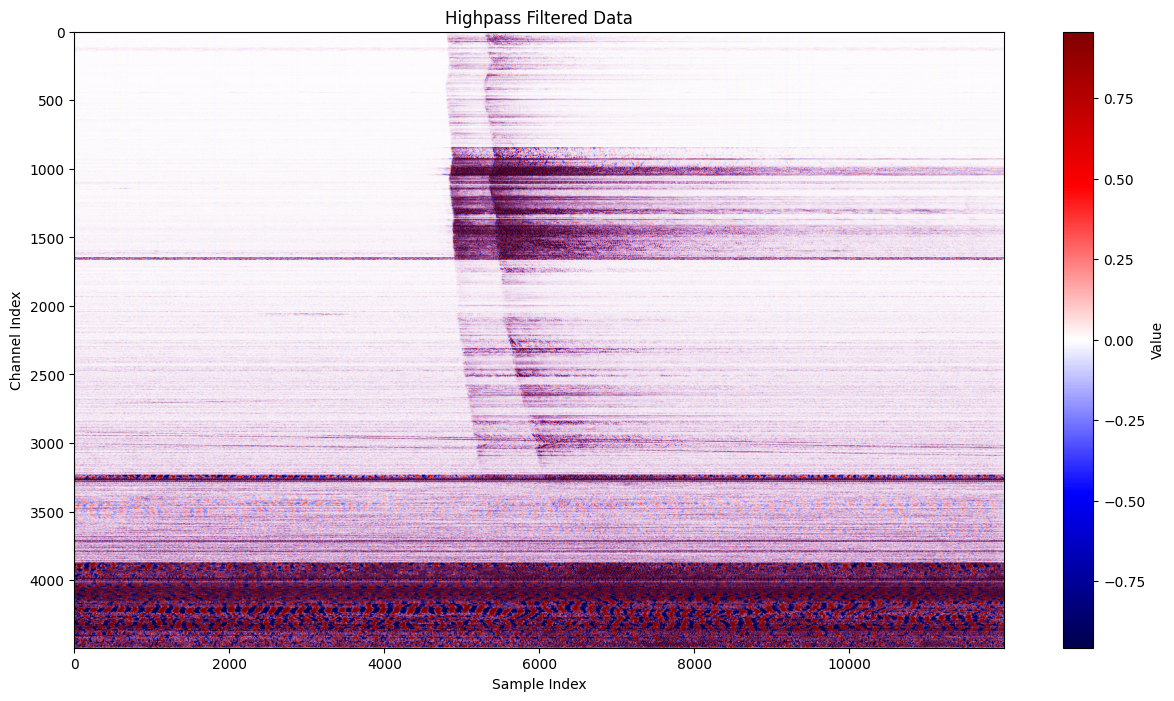

In [17]:
with h5py.File(eq_file_path, 'r', locking=False) as f:
    eq_data = f['Acquisition/Raw[0]/RawData'][:]
    
# Apply highpass filter
filtered_eq_data = highpass_filter(eq_data, cutoff, fs)
filtered_eq_data_norm = (filtered_eq_data - np.mean(filtered_eq_data)) / np.std(filtered_eq_data)
filtered_eq_data_max = np.percentile(np.abs(filtered_eq_data_norm), 90)
 
# Plot the filtered data
plt.figure(figsize=(15, 8))
plt.imshow(filtered_eq_data_norm.T, aspect='auto', cmap='seismic', vmin=-filtered_eq_data_max, vmax=filtered_eq_data_max)
plt.colorbar(label='Value')
plt.title("Highpass Filtered Data")
plt.xlabel("Sample Index")
plt.ylabel("Channel Index")
plt.show()

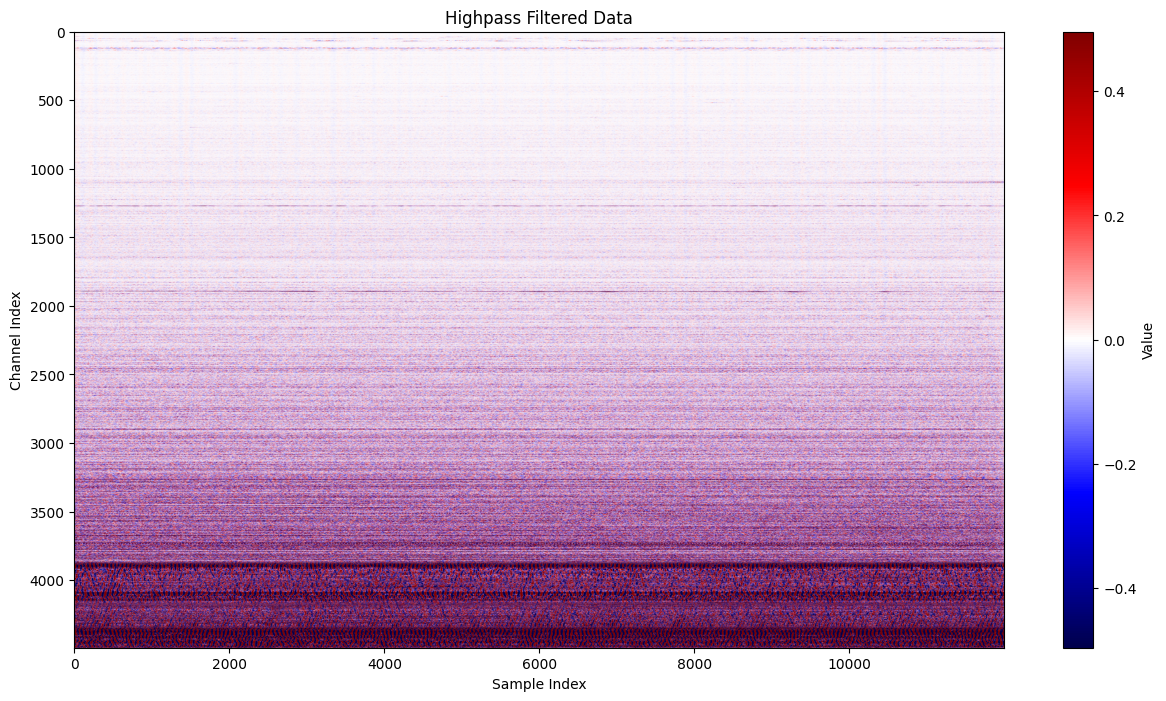

In [18]:
with h5py.File(car_file_path, 'r', locking=False) as f:
    car_data = f['Acquisition/Raw[0]/RawData'][:]
    
# Apply highpass filter
filtered_car_data = highpass_filter(car_data, cutoff, fs)
filtered_car_data_norm = (filtered_car_data - np.mean(filtered_car_data)) / np.std(filtered_car_data)
filtered_car_data_max = np.percentile(np.abs(filtered_car_data_norm), 90)
 
# Plot the filtered data
plt.figure(figsize=(15, 8))
plt.imshow(filtered_car_data_norm.T, aspect='auto', cmap='seismic', vmin=-filtered_car_data_max, vmax=filtered_car_data_max)
plt.colorbar(label='Value')
plt.title("Highpass Filtered Data")
plt.xlabel("Sample Index")
plt.ylabel("Channel Index")
plt.show()

Overlaying car data on earthquake data

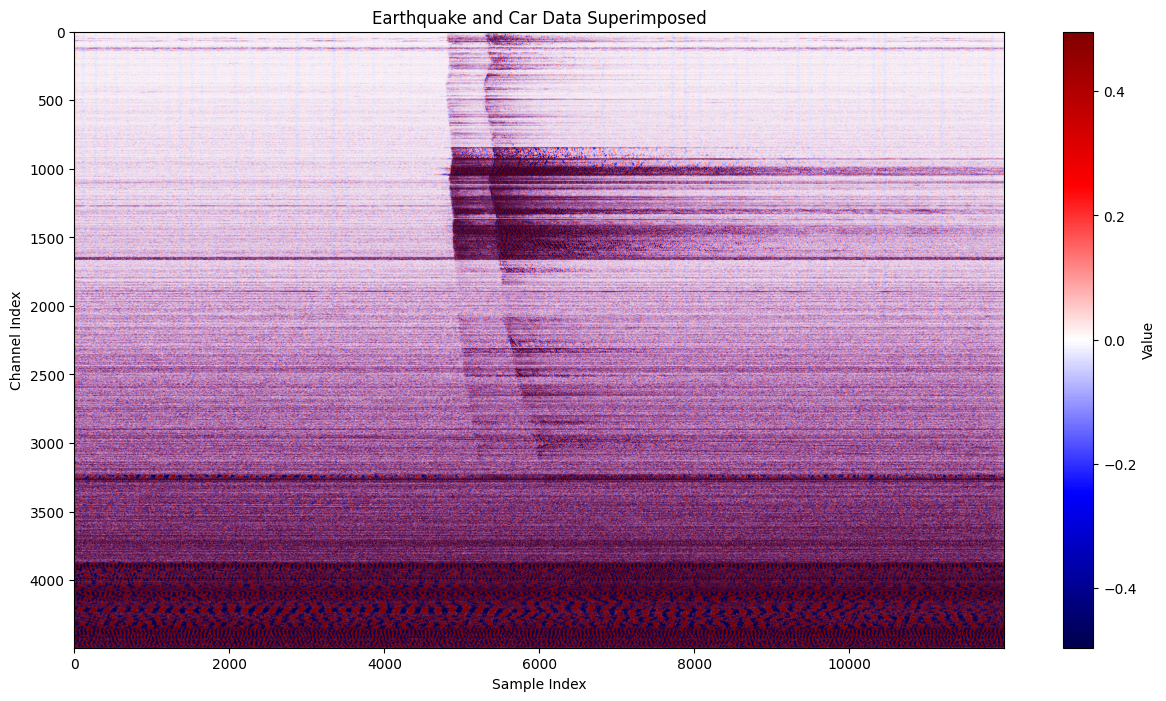

In [21]:
max_val = max(np.percentile(np.abs(filtered_eq_data_norm), 90), np.percentile(np.abs(filtered_car_data_norm), 90))

plt.figure(figsize=(15, 8))
plt.imshow(filtered_eq_data_norm.T + 3*filtered_car_data_norm.T, aspect='auto', cmap='seismic', vmin=-filtered_car_data_max, vmax=filtered_car_data_max)
plt.colorbar(label='Value')
plt.title("Earthquake and Car Data Superimposed")
plt.xlabel("Sample Index")
plt.ylabel("Channel Index")
plt.show()

Getting more earthquake data from Mt. Rainier (08/2023 - 11/2023)

In [7]:
# Load the CSV file
file_path = '/home/ajm76/FM_Denoising_DAS/data/mt_rainier.csv'
data = pd.read_csv(file_path)

# Create separate DataFrames for earthquakes and cars
eq_df = data[data['start_time'].notna()].copy()
car_df = data[data['start_time'].isna()].copy()

# Display the number of rows in each DataFrame
print(f"Number of earthquakes: {len(eq_df)}")
print(f"Number of cars: {len(car_df)}")
print(eq_df.columns)
print(car_df.columns)


Number of earthquakes: 41
Number of cars: 666
Index(['matched_file', 'longitude', 'latitude', 'distance_km', 'magnitude',
       'depth', 'original_date', 'DAS_visibility', 'start_time', 'end_time',
       'start_channel', 'end_channel'],
      dtype='object')
Index(['matched_file', 'longitude', 'latitude', 'distance_km', 'magnitude',
       'depth', 'original_date', 'DAS_visibility', 'start_time', 'end_time',
       'start_channel', 'end_channel'],
      dtype='object')


In [8]:
def extract_month_day(filename):
    parts = filename.split('_')
    date_part = parts[1]
    _, month, day = date_part.split('-')
    return month, day

print(extract_month_day(eq_df.iloc[2]['matched_file']))

('08', '27')


In [9]:
eq_file_paths = []
car_file_paths = []
for index, row in eq_df.iterrows():
    month, day = extract_month_day(row['matched_file'])
    eq_file_paths.append(f"/1-fnp/petasaur/p-jbod1/rainier/2023/{month}/{day}/{row['matched_file']}")
for index, row in car_df.iterrows():
    month, day = extract_month_day(row['matched_file'])
    car_file_paths.append(f"/1-fnp/petasaur/p-jbod1/rainier/2023/{month}/{day}/{row['matched_file']}")

In [10]:
eq_df = pd.DataFrame({'file_path': eq_file_paths, 'start_time': eq_df['start_time'], 'start_channel': eq_df['start_channel'], 
                    'end_channel': eq_df['end_channel']})
car_df = pd.DataFrame({'file_path': car_file_paths, 'start_time': car_df['start_time'], 'start_channel': car_df['start_channel']})
print(eq_df.columns)
print(car_df.columns)

Index(['file_path', 'start_time', 'start_channel', 'end_channel'], dtype='object')
Index(['file_path', 'start_time', 'start_channel'], dtype='object')


In [ ]:
def split_large_chunks(eq_df):
    new_rows = []
    for _, row in eq_df.iterrows():
        start_channel = row['start_channel']
        end_channel = row['end_channel']
        
        # Check if end_channel is greater than start_channel + 1500
        if not pd.isna(start_channel) and not pd.isna(end_channel) and end_channel > start_channel + 1500:
            current_start = start_channel
            while current_start + 1500 <= end_channel:
                new_row = row.copy()
                new_row['start_channel'] = current_start
                new_row['end_channel'] = current_start + 1500
                new_rows.append(new_row)
                current_start += 250
        else:
            new_rows.append(row)
    
    # Create a new DataFrame with the updated rows
    return pd.DataFrame(new_rows)

eq_df = split_large_chunks(eq_df)

In [14]:
print(eq_df.shape)

(92, 4)


In [22]:
results = []

for _, row in eq_df.iterrows():
    file_path = row['file_path']
    start_time = row['start_time']
    end_time = start_time + 1500
    start_channel = row['start_channel']
    end_channel = start_channel + 1500
    
    if pd.notna(start_time) and pd.notna(end_time) and pd.notna(start_channel) and pd.notna(end_channel):
        with h5py.File(file_path, 'r', locking=False) as f:
            eq_data = f['Acquisition/Raw[0]/RawData'][:]
            
            # Extract the chunk
            eq_data_section = eq_data[int(start_time):int(end_time), int(start_channel):int(end_channel)]
            
            # Apply highpass filter
            filtered_eq_data = highpass_filter(eq_data_section, cutoff, fs)
            
            # Compute the norm
            filtered_eq_data_norm = (filtered_eq_data - np.mean(filtered_eq_data)) / np.std(filtered_eq_data)

            # Choose 10 random car files
            car_file_paths = np.random.choice(car_df["file_path"].tolist(), 10, replace=False)
            for car_file_path in car_file_paths:
                with h5py.File(car_file_path, 'r', locking=False) as cf:
                    car_data = cf['Acquisition/Raw[0]/RawData'][:]

                    # Choose a random start time and channel
                    car_start_time = np.random.randint(0, car_data.shape[0] - 1500)
                    car_end_time = car_start_time + 1500
                    car_start_channel = np.random.randint(0, car_data.shape[1] - 1500)
                    car_end_channel = car_start_channel + 1500
                    
                    # Extract the chunk
                    car_data_section = car_data[car_start_time:car_end_time, car_start_channel:car_end_channel]
                    
                    # Apply highpass filter
                    filtered_car_data = highpass_filter(car_data_section, cutoff, fs)
                    
                    # Compute the norm
                    filtered_car_data_norm = (filtered_car_data - np.mean(filtered_car_data)) / np.std(filtered_car_data)
                    
                    # Choose a random number between 0.1 and 1
                    scale = np.random.uniform(0.1, 1)
                    final_data = filtered_eq_data + (scale * filtered_car_data_norm)
                    results.append(final_data)

In [24]:
print(len(results))
print(results[0].shape)
print(type(results))

900
(1500, 1500)
<class 'list'>


In [ ]:
# Save the results to to a h5 file
data_file_path = 'mt_rainier_eq_car_data.h5'
data_list = []

with h5py.File(data_file_path, 'r') as f:
    for key in f.keys():
        data = f[key][()]  # Load the dataset as a NumPy array
        data_list.append(data)

print(len(data_list))
print(data_list[0].shape)

900
(1500, 1500)
